In [2]:
# Step 1: synthetic dataset (run in local Python / Jupyter)
import numpy as np
import pandas as pd
from datetime import datetime
np.random.seed(42)

T = 600                # total observations (>=500)
period = 12            # monthly seasonality
dates = pd.date_range("2000-01-01", periods=T, freq="M")

# --- Latent state: [level, trend, seasonal_sin, seasonal_cos]
n_state = 4
phi = 2 * np.pi / period
decay = 0.995   # slight damping for seasonal rotation

F = np.eye(n_state)
F[0,0] = 1.0; F[0,1] = 1.0    # level <- level + trend
F[1,1] = 1.0                  # trend persistence
F[2,2] = decay * np.cos(phi)
F[2,3] = -decay * np.sin(phi)
F[3,2] = decay * np.sin(phi)
F[3,3] = decay * np.cos(phi)

# process noise variances (true)
Q_true = np.diag([0.01, 0.002, 0.005, 0.005])

# Observation matrix: two observed series are different mixes of the state
H = np.zeros((2, n_state))
H[0,0] = 1.0; H[0,1] = 0.4; H[0,2] = 1.0   # y1: level + trend + sin comp
H[1,0] = 0.8; H[1,1] = 0.1; H[1,3] = 1.2   # y2: level + trend + cos comp

R_true = np.diag([0.3, 0.5])  # observation noise variances

# simulate states + observations
x = np.zeros((T, n_state))
y = np.zeros((T, 2))
x[0] = np.array([1.0, 0.02, 0.5, -0.2])

for t in range(1, T):
    w = np.random.multivariate_normal(np.zeros(n_state), Q_true)
    x[t] = F.dot(x[t-1]) + w
    v = np.random.multivariate_normal(np.zeros(2), R_true)
    y[t] = H.dot(x[t]) + v

# DataFrames and saving
df = pd.DataFrame(y, index=dates, columns=["y1", "y2"])
df_states = pd.DataFrame(x, index=dates, columns=["level","trend","sin","cos"])

# Save (change path as you like)
df.to_csv("synthetic_multivariate_series.csv")
df_states.to_csv("true_states.csv")

print("Saved synthetic_multivariate_series.csv and true_states.csv")
print("First 5 rows of the generated observed series:")
print(df.head())

Saved synthetic_multivariate_series.csv and true_states.csv
First 5 rows of the generated observed series:
                  y1        y2
2000-01-31  0.000000  0.000000
2000-02-29  1.552820  0.778938
2000-03-31  1.535679  1.214096
2000-04-30  1.709784  0.960670
2000-05-31  0.636434  1.561015


C:\Users\amrit\AppData\Local\Temp\ipykernel_14180\1699600167.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2000-01-01", periods=T, freq="M")


In [3]:
#plot your dataset
import pandas as pd
df = pd.read_csv("synthetic_multivariate_series.csv")
df.head()

,Unnamed: 0,y1,y2
0,2000-01-31,0.000000,0.000000
1,2000-02-29,1.552820,0.778938
2,2000-03-31,1.535679,1.214096
3,2000-04-30,1.709784,0.960670
4,2000-05-31,0.636434,1.561015


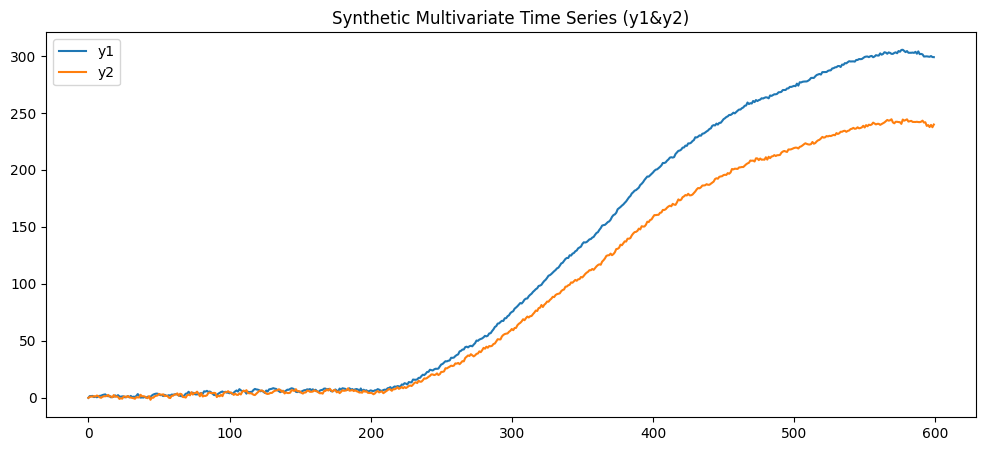

In [4]:
import matplotlib.pyplot as plt
df.plot(figsize=(12,5))
plt.title("Synthetic Multivariate Time Series (y1&y2)")
plt.show()

In [5]:
#split in to train and test
train_size = 500
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]
print(train_df.shape,test_df.shape)

(500, 3) (100, 3)


In [6]:
#build the kalman filter
import numpy as np

def kalman_filter(y, F, H, Q, R, x0, P0):
    """
    y : observations (2 x T)
    F : transition matrix (4 x 4)
    H : observation matrix (2 x 4)
    Q : process noise covariance
    R : measurement noise covariance
    x0 : initial state
    P0 : initial covariance
    """
    n_state = F.shape[0]
    n_obs, T = y.shape
    
    xs = np.zeros((T, n_state))        # filtered states
    Ps = np.zeros((T, n_state, n_state))
    
    x = x0
    P = P0
    
    for t in range(T):
        # ---------- PREDICTION ----------
        x_pred = F @ x
        P_pred = F @ P @ F.T + Q
        
        # ---------- UPDATE ----------
        y_pred = H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        
        innovation = y[:, t] - y_pred
        
        x = x_pred + K @ innovation
        P = (np.eye(n_state) - K @ H) @ P_pred
        
        xs[t] = x
        Ps[t] = P
    
    return xs, Ps

In [9]:
#run the kalman filter on your trainig data
# Convert train data to matrix shape (2 x T)
train_y = train_df[["y1","y2"]].values.T

# Initial state guess
x0 = np.zeros(4)
P0 = np.eye(4)

# Use true Q and R for now
xs, Ps = kalman_filter(train_y, F, H, Q_true, R_true, x0, P0)

xs[:5]   # show first 5 filtered state estimates

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.1587206 ,  0.72729926, -0.1492366 , -0.36621073],
       [ 1.40130902,  0.56642987,  0.07524911, -0.06913987],
       [ 1.56342925,  0.40503196,  0.12723306,  0.02021133],
       [ 1.13606782,  0.20699223, -0.01399464,  0.4927517 ]])

In [10]:
#forecasting using the kalman filter
#extract final filtered state
# Last filtered state and covariance
x_last = xs[-1]
P_last = Ps[-1]

In [11]:
#forecast future steps (without measurement updates)
def kalman_forecast(F, H, Q, x_last, P_last, steps=100):
    forecasts = []
    
    x = x_last.copy()
    P = P_last.copy()
    
    for _ in range(steps):
        # predict next state
        x = F @ x
        P = F @ P @ F.T + Q
        
        # predicted observation
        y_pred = H @ x
        forecasts.append(y_pred)
    
    return np.array(forecasts)

In [12]:
#genrate forecast
test_steps = len(test_df)

forecast = kalman_forecast(F, H, Q_true, x_last, P_last, steps=test_steps)
forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=["y1_pred","y2_pred"])

forecast_df.head()

,y1_pred,y2_pred
500,274.146619,219.100285
501,274.798590,219.570004
502,275.446336,220.073516
503,276.076431,220.603626
504,276.680290,221.146116


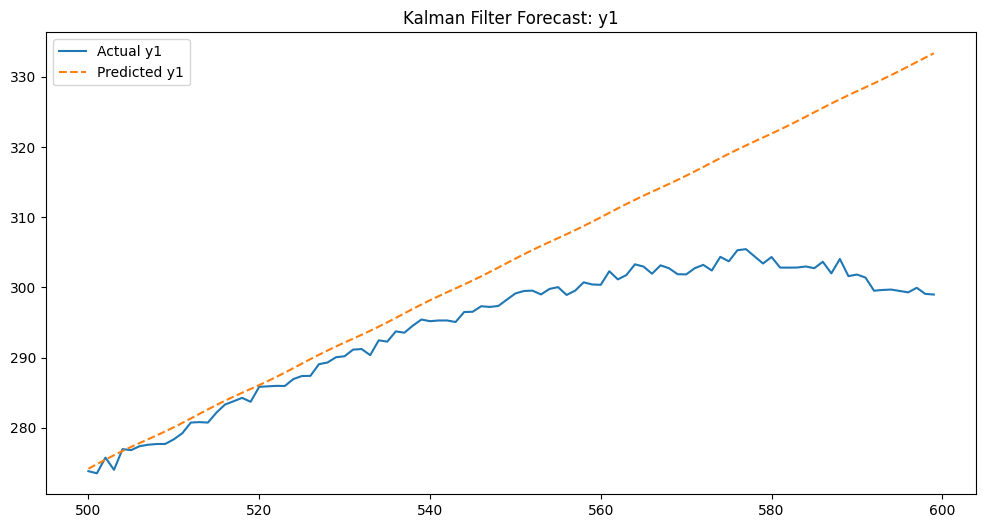

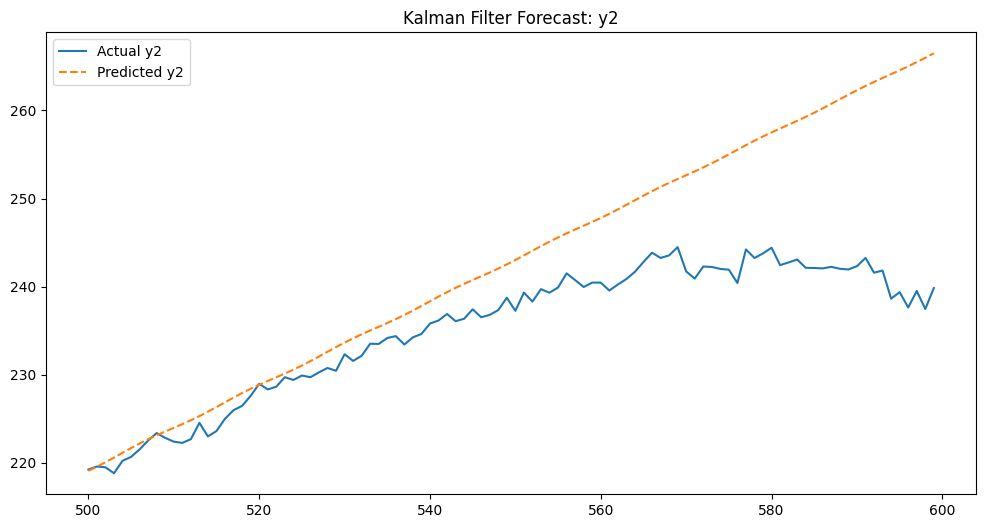

In [13]:
#plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(test_df["y1"], label="Actual y1")
plt.plot(forecast_df["y1_pred"], label="Predicted y1", linestyle="--")
plt.legend()
plt.title("Kalman Filter Forecast: y1")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_df["y2"], label="Actual y2")
plt.plot(forecast_df["y2_pred"], label="Predicted y2", linestyle="--")
plt.legend()
plt.title("Kalman Filter Forecast: y2")
plt.show()

In [14]:
#compute rmse
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_y1 = np.sqrt(mean_squared_error(test_df["y1"], forecast_df["y1_pred"]))
rmse_y2 = np.sqrt(mean_squared_error(test_df["y2"], forecast_df["y2_pred"]))

print("RMSE y1:", rmse_y1)
print("RMSE y2:", rmse_y2)

RMSE y1: 13.594083501060021
RMSE y2: 10.819433053819967


Starting optimization (this may take a little while)...


C:\Users\amrit\AppData\Local\Temp\ipykernel_14180\3169751304.py:110: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(neg_loglik, p0, args=(train_y, F, H, x0, P0), method="L-BFGS-B", bounds=bnds,


Optimization success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Number of iterations: 15
Estimated Q diagonal: [0.02847702 0.00188966 0.00500063 0.00500063]
Estimated R diagonal: [0.28089022 0.49457241]
Train log-likelihood (est): -1125.4770986266747
RMSE y1 (SSM with estimated Q/R): 12.927695122557223
RMSE y2 (SSM with estimated Q/R): 10.286576415067527


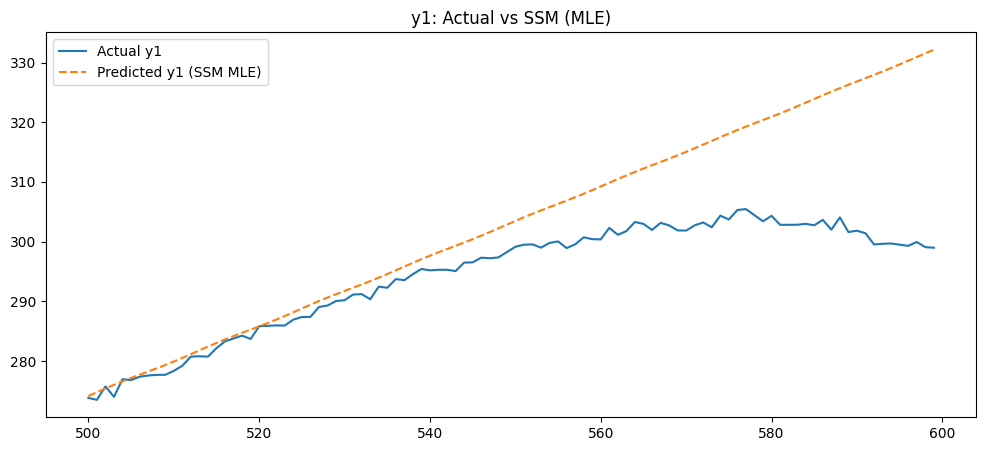

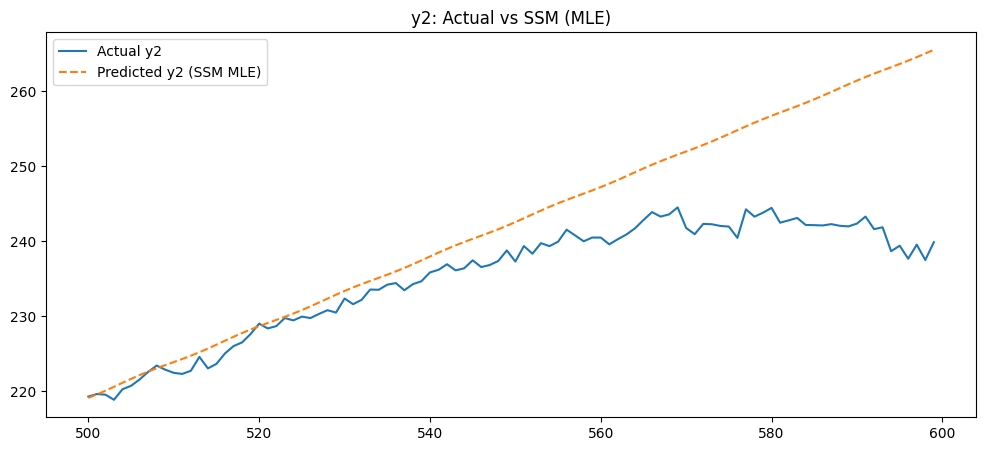

In [16]:
# Step 5: MLE for Q and R (run in notebook)
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ---------- Helper: softplus to ensure positivity ----------
def softplus(x):
    return np.log1p(np.exp(x))

# ---------- Kalman filter that also returns loglik ----------
def kalman_filter_with_loglik(y_obs, F, H, Q, R, x0=None, P0=None):
    """
    y_obs: shape (n_obs, T)
    Returns: filtered states xs (T x n_state), Ps (T x n_state x n_state), loglik (scalar)
    """
    n_obs, T = y_obs.shape
    n_state = F.shape[0]
    if x0 is None:
        x_prev = np.zeros(n_state)
    else:
        x_prev = x0.copy()
    if P0 is None:
        P_prev = np.eye(n_state) * 1.0
    else:
        P_prev = P0.copy()
    xs = np.zeros((T, n_state))
    Ps = np.zeros((T, n_state, n_state))
    loglik = 0.0
    for t in range(T):
        # Predict
        x_pred = F.dot(x_prev)
        P_pred = F.dot(P_prev).dot(F.T) + Q
        # Observation prediction
        y_pred = H.dot(x_pred)
        S = H.dot(P_pred).dot(H.T) + R
        # Inverse and gain
        try:
            S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.pinv(S)
        K = P_pred.dot(H.T).dot(S_inv)
        # Update
        y_t = y_obs[:, t]
        innov = y_t - y_pred
        x_upd = x_pred + K.dot(innov)
        P_upd = P_pred - K.dot(H).dot(P_pred)
        xs[t] = x_upd
        Ps[t] = P_upd
        # Log-likelihood contribution
        sign, logdet = np.linalg.slogdet(S)
        if sign <= 0:
            # Numerical issue: penalize
            loglik += -1e9
        else:
            loglik += -0.5 * (n_obs * np.log(2 * np.pi) + logdet + innov.T.dot(S_inv).dot(innov))
        # iterate
        x_prev = x_upd
        P_prev = P_upd
    return xs, Ps, loglik

# ---------- Prepare training data in matrix form ----------
# Ensure explicit selection of y1,y2 to avoid shape issues
train_y = train_df[["y1","y2"]].values.T  # shape (2, T)
n_state = F.shape[0]
n_obs = H.shape[0]

# ---------- Mapping from parameter vector to Q and R ----------
# We'll estimate 5 parameters: [q_level, q_trend, q_season, r1, r2]
def params_to_QR(p):
    # p is real-valued; map to positive via softplus
    q_level = softplus(p[0])
    q_trend = softplus(p[1])
    q_season = softplus(p[2])
    r1 = softplus(p[3])
    r2 = softplus(p[4])
    Q = np.zeros((n_state, n_state))
    Q[0,0] = q_level
    Q[1,1] = q_trend
    # shared variance for both seasonal components
    Q[2,2] = q_season
    Q[3,3] = q_season
    R = np.diag([r1, r2])
    return Q, R

# ---------- Negative log-likelihood objective ----------
def neg_loglik(p, y_obs, F, H, x0=None, P0=None):
    Q, R = params_to_QR(p)
    _, _, loglik = kalman_filter_with_loglik(y_obs, F, H, Q, R, x0=x0, P0=P0)
    return -loglik

# ---------- Initial guess ----------
# A log-scale-ish guess; small positive values work
p0 = np.array([np.log(0.01), np.log(0.002), np.log(0.005), np.log(0.3), np.log(0.5)])
# We use the real-values but they will be mapped. 
# To help optimizer, use raw values near true (optional)
# You can just use zeros: p0 = np.zeros(5)

# ---------- Bounds (in real space) to avoid huge values ----------
# We bound p to [-10, 10] which after softplus yields variances in a reasonable range
bnds = [(-10, 10)] * len(p0)

# ---------- Optional: initial state and covariance for Kalman filter in the likelihood ----------
x0 = np.zeros(n_state)
P0 = np.eye(n_state) * 1.0

# ---------- Run optimization ----------
print("Starting optimization (this may take a little while)...")
res = minimize(neg_loglik, p0, args=(train_y, F, H, x0, P0), method="L-BFGS-B", bounds=bnds,
               options={"maxiter": 500, "disp": True})

print("Optimization success:", res.success)
print("Message:", res.message)
print("Number of iterations:", res.nit)

# ---------- Extract estimated Q and R ----------
p_est = res.x
Q_est, R_est = params_to_QR(p_est)
print("Estimated Q diagonal:", np.diag(Q_est))
print("Estimated R diagonal:", np.diag(R_est))

# ---------- Re-run Kalman filter with estimated Q/R ----------
xs_est, Ps_est, loglik_est = kalman_filter_with_loglik(train_y, F, H, Q_est, R_est, x0=x0, P0=P0)
print("Train log-likelihood (est):", loglik_est)

# ---------- Forecast using final filtered state ----------
def forecast_from_state(x_last, F, H, steps):
    preds = []
    x = x_last.copy()
    for s in range(steps):
        x = F.dot(x)
        preds.append(H.dot(x))
    return np.array(preds).T  # shape (n_obs, steps)

x_last = xs_est[-1]
steps = len(test_df)
preds = forecast_from_state(x_last, F, H, steps)
pred_df = pd.DataFrame(preds.T, index=test_df.index, columns=["y1_pred", "y2_pred"])

# ---------- Evaluate forecasts ----------
rmse_y1 = np.sqrt(mean_squared_error(test_df["y1"], pred_df["y1_pred"]))
rmse_y2 = np.sqrt(mean_squared_error(test_df["y2"], pred_df["y2_pred"]))
print("RMSE y1 (SSM with estimated Q/R):", rmse_y1)
print("RMSE y2 (SSM with estimated Q/R):", rmse_y2)

# ---------- Plot actual vs predicted ----------
plt.figure(figsize=(12,5))
plt.plot(test_df["y1"], label="Actual y1")
plt.plot(pred_df["y1_pred"], linestyle="--", label="Predicted y1 (SSM MLE)")
plt.legend(); plt.title("y1: Actual vs SSM (MLE)"); plt.show()

plt.figure(figsize=(12,5))
plt.plot(test_df["y2"], label="Actual y2")
plt.plot(pred_df["y2_pred"], linestyle="--", label="Predicted y2 (SSM MLE)")
plt.legend(); plt.title("y2: Actual vs SSM (MLE)"); plt.show()

In [25]:
# -----------------------------
# STEP 6 – Baseline SARIMA vs Kalman Filter Forecast Comparison
# -----------------------------

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -----------------------------
# Helper: RMSE function
# -----------------------------
def rmse(true, pred):
    return np.sqrt(np.mean((true - pred)**2))


# -----------------------------
# 1. BASELINE FORECAST (SARIMA)
# -----------------------------
print("Fitting SARIMA baseline model...")

# You can tune order if you want
sarima_y1 = SARIMAX(train_df["y1"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
sarima_y2 = SARIMAX(train_df["y2"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)

forecast_y1 = sarima_y1.get_forecast(steps=len(test_df)).predicted_mean
forecast_y2 = sarima_y2.get_forecast(steps=len(test_df)).predicted_mean


# -----------------------------
# 2. KALMAN FILTER FORECAST ON TEST SET
# -----------------------------
print("Generating Kalman Filter forecasts...")

H_steps = len(test_df)

# Initial forecast state = last filtered state from TRAIN
x_last = xs[-1]           
P_last = Ps[-1]           

kf_forecasts = []
x_fore = x_last
P_fore = P_last

for _ in range(H_steps):
    # Predict next state
    x_pred = F @ x_fore
    P_pred = F @ P_fore @ F.T + Q_est

    # Predict observation
    y_pred = H @ x_pred
    kf_forecasts.append(y_pred)

    # Update for next iteration (prediction-only mode)
    x_fore = x_pred
    P_fore = P_pred

kf_forecasts = np.array(kf_forecasts)   # shape = (test_length, 2)


# -----------------------------
# 3. COMPUTE RMSE FOR BOTH METHODS
# -----------------------------
rmse_y1_kf = rmse(test_df["y1"].values, kf_forecasts[:,0])
rmse_y2_kf = rmse(test_df["y2"].values, kf_forecasts[:,1])

rmse_y1_sarima = rmse(test_df["y1"].values, forecast_y1.values)
rmse_y2_sarima = rmse(test_df["y2"].values, forecast_y2.values)


# -----------------------------
# 4. PRINT RESULTS
# -----------------------------
print("\n========== FORECAST RMSE COMPARISON ==========")
print(f"Kalman Filter RMSE - y1: {rmse_y1_kf:.4f}")
print(f"Kalman Filter RMSE - y2: {rmse_y2_kf:.4f}")

print(f"SARIMA RMSE - y1:       {rmse_y1_sarima:.4f}")
print(f"SARIMA RMSE - y2:       {rmse_y2_sarima:.4f}")

print("==============================================")

Fitting SARIMA baseline model...
Generating Kalman Filter forecasts...

========== FORECAST RMSE COMPARISON ==========
Kalman Filter RMSE - y1: 102.6658
Kalman Filter RMSE - y2: 82.2492
SARIMA RMSE - y1:       45.4007
SARIMA RMSE - y2:       35.3052
